# Table of Contents <a id="table-of-contents"></a>

- [Imports](#imports)
- [Data Loading](#data-loading)
- [Data Overview](#data-overview)
    - [Number of Samples](#number-of-samples)
    - [Sample Data](#sample-data)
- [Viewing the OCT Images](#viewing-the-oct-images)
    - [Axial View](#axial-view)
    - [Coronal View](#coronal-view)
    - [Sagittal View](#sagittal-view)
- [Data Splitting](#data-splitting)
    - [Train/Test/Validation Split](#train-test-validation-split)
    - [Class Distribution](#class-distribution)
- [Data Augmentation](#data-augmentation)
    - [Augmentation Methods](#augmentation-methods)
    - [Augmentation Results](#augmentation-results)
- [Histograms](#histograms)
    - [Brightness](#brightness)
    - [Contrast](#contrast)
    - [Gamma Correction](#gamma-correction)

# Imports <a id="imports"></a>

In [14]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import time
import numpy as np
from IPython.display import clear_output
import cv2 as cv

<a id="data-loading"></a>
# Data Loading
[Back to Top](#table-of-contents)

In [15]:
import data_load

data_loader = data_load.DataLoader()
image_data, np_array_data, labels_data = data_loader.retina()

In [16]:
print(len(image_data))
print(len(np_array_data))
print(len(labels_data))

884
884
884


In [17]:
%%capture
print(image_data[0])

In [18]:
%%capture
print(np_array_data[0])

In [19]:
#%%capture
print("poaGlaucoma: ", sum(labels_data), "  Healthy:", len(labels_data)-sum(labels_data))

poaGlaucoma:  677   Healthy: 207


# Viewing the OCT images
[Back to Top](#table-of-contents)
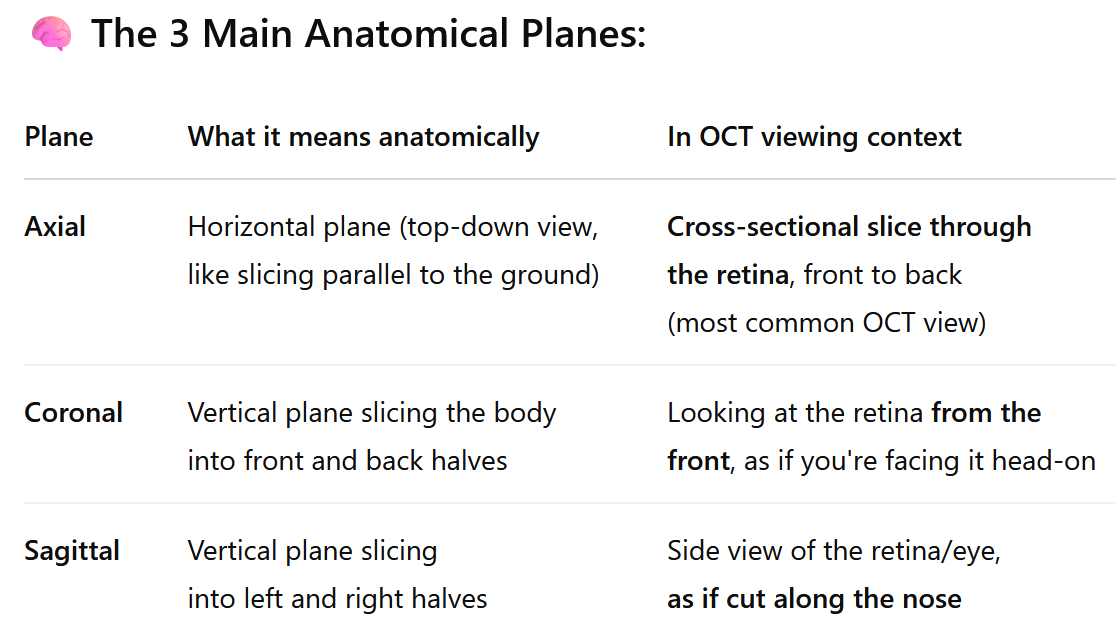


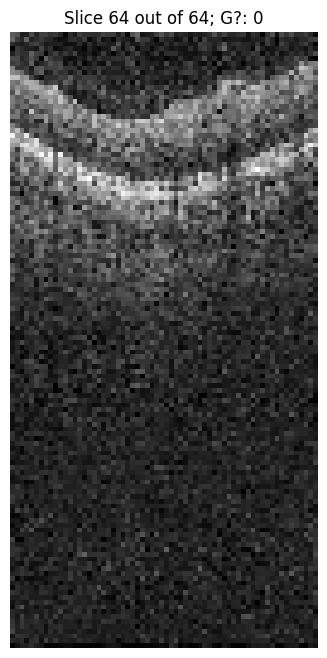

In [ ]:
id = 35
array = np_array_data[id]
label = labels_data[id]

# Display axial view 
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    time.sleep(0.3)
    clear_output(wait=True)



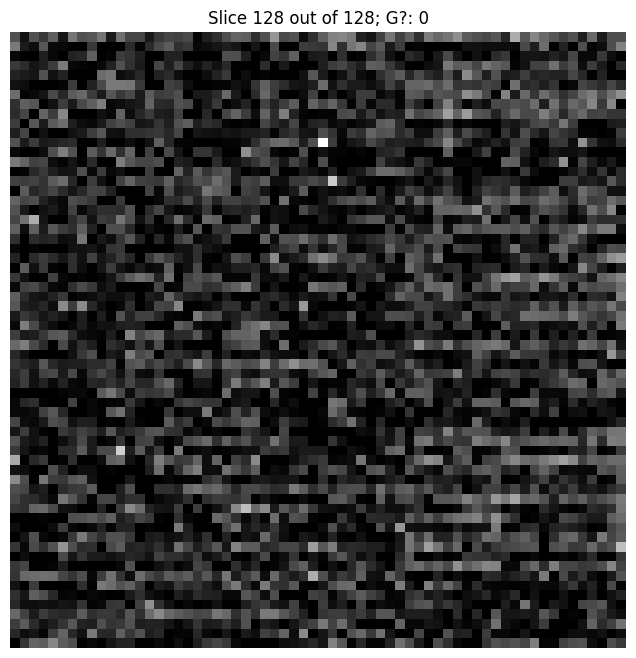

In [14]:
# Display coronal view
# This view shows a slice of the retina from the front to the back
# This view is going from the top to the bottom in the previous view (birds eye view)
# Note the nerve structure in the centre of the image towards to second half of the anymation
for i in range(array.shape[1]):
    slice_num = i
    slice = array[:, slice_num, :]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[1]}; G?: {label}")
    plt.axis('off')
    plt.show()
    time.sleep(0.3)
    clear_output(wait=True)

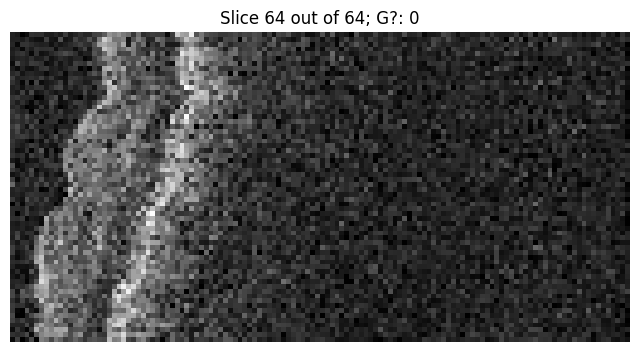

In [15]:
# Display sagittal view
for i in range(array.shape[2]):
    slice_num = i
    slice = array[:, :, slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[2]}; G?: {label}")
    plt.axis('off')
    plt.show()
    time.sleep(0.3)
    clear_output(wait=True)

# Splitting the data
[Back to Top](#table-of-contents)

In [20]:
X_train, X_test, X_val, y_train, y_test, y_val = data_loader.retina_split(np_array_data,labels_data)

In [21]:
print(len(X_train),len(X_test),len(X_val))

600 177 107


In [22]:
train_positive_pecentage = sum(y_train)/len(y_train)
test_positive_pecentage = sum(y_test)/len(y_test)
val_positive_pecentage = sum(y_val)/len(y_val)

print("train positives:", np.round(train_positive_pecentage,3), "  ---  test positives:", np.round(test_positive_pecentage,3), "  ---  val positives:", np.round(val_positive_pecentage,3))

train positives: 0.76   ---  test positives: 0.791   ---  val positives: 0.757


# Data Augmentation
[Back to Top](#table-of-contents)

The data is between 70% and 80% glaucoma positive.

- How many images should I produce:
    - balance out the healthy class
    - See results below



In [23]:
# healthy = 0 vs glaucomatous = 1 in the train data
glaucoma = sum(y_train)
glaucoma_cent = glaucoma/len(y_train)
healthy = len(y_train) - glaucoma
healthy_cent = healthy/len(y_train)
print("healthy: ", healthy,"healthy percentage:", np.round(healthy_cent, 4))
print("glaucoma: ", glaucoma,"glaucoma percentage:", np.round(glaucoma_cent, 4))
print("Samples to be produced in augmentation: ", glaucoma-healthy)

healthy:  144 healthy percentage: 0.24
glaucoma:  456 glaucoma percentage: 0.76
Samples to be produced in augmentation:  312


## Methods
[Back to Top](#table-of-contents)
- Over- or undersampling?
    - undersampling risks information loss
        - Undersampling with ensemble learning
    - oversampling
        - seems unrealistic for images as techniques are built for tabular data
- image transformations? -> these are medical images so not all transformations are realistic and sensible
- The methods below seem reasonable
    - Intensity based augmentations
        - Brightness adjustment
        - Contrast changes
        - Gamma correction
        - Histogram equalization
        - Gaussian noise (to simulate acquisition noise)
        - Blurring/sharpening
    - Affine transfomations (mild)
        - small translations
        - mild scaling
        - elastic deformation (simulate soft tissue variation)
    - cutout/random erasing
        - how would this relate to ROAR/ patch based training



In [ ]:
# TODO: verify runnability after implementation of augmentation methods
import data_augmentation as aug

num_new_images = glaucoma-healthy
augmenter = aug.AugmentData(X_train, y_train)
print("Samples produced in augmentation: ", num_new_images)
X_train_augmented, y_train_augmented = augmenter.augment_data(num_new_images, return_values="comlete")
print("augmented data shape: ", X_train_augmented.shape, y_train_augmented.shape)
glaucoma = sum(y_train_augmented)
glaucoma_cent = glaucoma/len(y_train_augmented)
healthy = len(y_train_augmented) - glaucoma
healthy_cent = healthy/len(y_train_augmented)
print("aug healthy: ", healthy,"aug healthy percentage:", np.round(healthy_cent, 4))
print("aug glaucoma: ", glaucoma,"aug glaucoma percentage:", np.round(glaucoma_cent, 4))

np.uint8(0)

<a id="histograms"></a>
### Histograms before and after augmentation
[Back to Top](#table-of-contents)

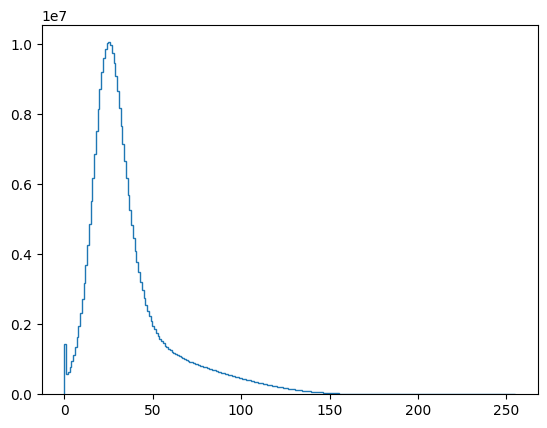

In [31]:
# before
hist, bin_edges =np.histogram(X_train, 256, range=(0, 255))
plt.stairs(hist, bin_edges)

#### Brightness
[Back to Top](#table-of-contents)

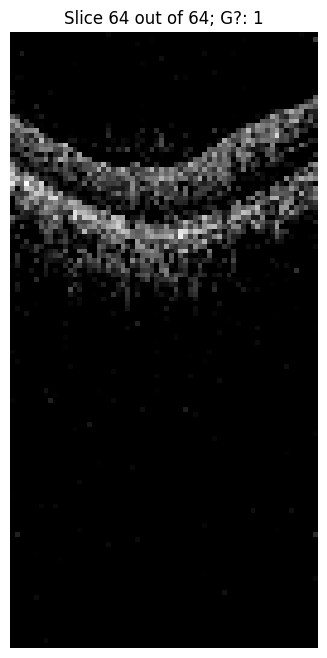

In [144]:
id = 479
brightness = -50
array = np_array_data[id].astype(int)
label = labels_data[id]
array = np.clip(array + brightness, 0, 255).astype(np.uint8)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    time.sleep(0.3)
    clear_output(wait=True)

In [ ]:
bright =[image.astype(int)-40 for image in X_train]
hist_min, bin_edges_min =np.histogram(np.clip(bright, 0, 255).astype(np.uint8), 256, range=(0, 255))
lowlight = [image.astype(int)+40 for image in X_train]
hist_max, bin_edges_max =np.histogram(np.clip(lowlight, 0, 255).astype(np.uint8), 256, range=(0, 255))

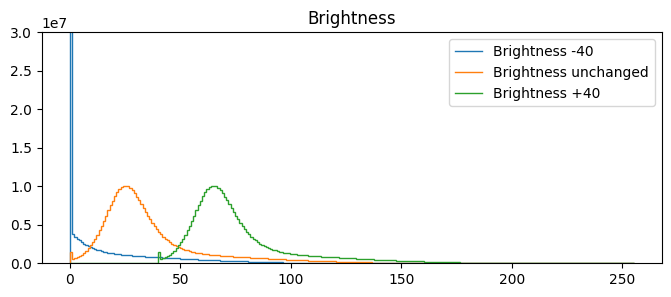

In [138]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_min, bin_edges_min, label='Brightness -40')
axs.stairs(hist, bin_edges, label='Brightness unchanged')
axs.stairs(hist_max, bin_edges_max, label='Brightness +40')
axs.set_title("Brightness")
axs.set_ylim([0, 30000000])
axs.legend()

#### Contrast
[Back to Top](#table-of-contents)

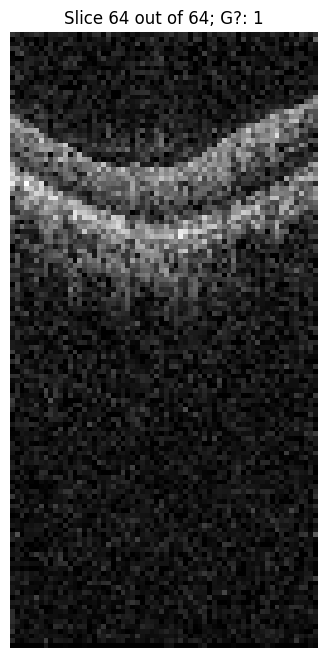

In [146]:
id = 479
contrast_factor = 1.5
array = np_array_data[id].astype(int)
label = labels_data[id]
array = np.clip((array - np.mean(array)) * contrast_factor + np.mean(array), 0, 255).astype(np.uint8)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    time.sleep(0.3)
    clear_output(wait=True)

In [147]:
hist_cont_min, bin_edges_cont_min =np.histogram(np.clip([(image.astype(int) - np.mean(image)) * 0.5 + np.mean(image) for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))
hist_cont_max, bin_edges_cont_max =np.histogram(np.clip([(image.astype(int) - np.mean(image)) * 1.5 + np.mean(image) for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))

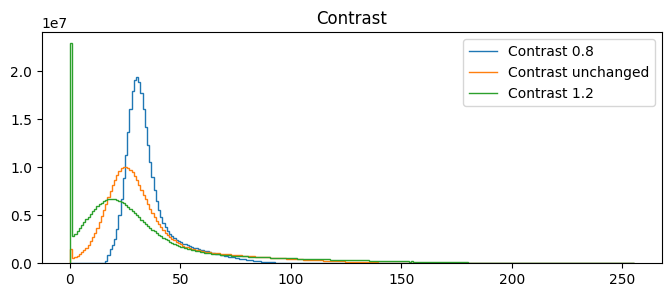

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_cont_min, bin_edges_cont_min, label='Contrast 0.5')
axs.stairs(hist, bin_edges, label='Contrast unchanged')
axs.stairs(hist_cont_max, bin_edges_cont_max, label='Contrast 1.5')
axs.set_title("Contrast")
# axs.set_ylim([0, 30000000])
axs.legend()

#### Gamma correction
[Back to Top](#table-of-contents)

In [ ]:
def gamma_correction(image, gamma):
    lookUpTable = np.empty((1,256))
    for i in range(256):
        lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255).astype(np.uint8)
    return cv.LUT(image, lookUpTable)

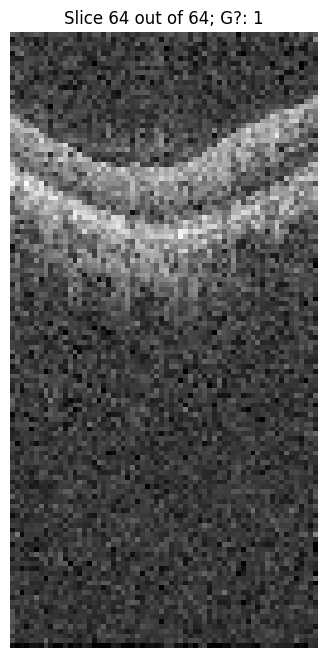

In [34]:
id = 479
gamma = 0.75
array = np_array_data[id]
label = labels_data[id]
array = gamma_correction(array, gamma)
for i in range(array.shape[0]):
    slice_num = i
    slice = array[slice_num]
    plt.figure(figsize=(8, 8))
    plt.imshow(slice, cmap='gray')
    plt.title(f"Slice {slice_num+1} out of {array.shape[0]}; G?: {label}")
    plt.axis('off')
    plt.show()
    time.sleep(0.3)
    clear_output(wait=True)

In [29]:
hist_gamma_min, bin_edges_gamma_min =np.histogram(np.clip([gamma_correction(image, 0.75) for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))
hist_gamma_max, bin_edges_gamma_max =np.histogram(np.clip([gamma_correction(image, 1.5 )for image in X_train], 0, 255).astype(np.uint8), 256, range=(0, 255))

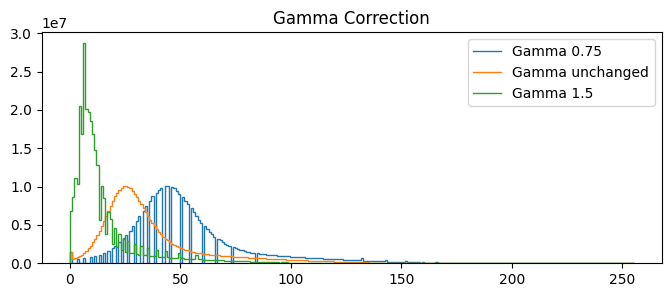

In [32]:
fig, axs = plt.subplots(1, 1, figsize=(8,3))
axs.stairs(hist_gamma_min, bin_edges_gamma_min, label='Gamma 0.75')
axs.stairs(hist, bin_edges, label='Gamma unchanged')
axs.stairs(hist_gamma_max, bin_edges_gamma_max, label='Gamma 1.5')
axs.set_title("Gamma Correction")
# axs.set_ylim([0, 30000000])
axs.legend()